<h1 style="text-align: center;">H04U1C - Optimization of Mechatronic Systems</h1>

Consider the mass-spring-damper test setup depicted in the figure below, which you can consider as a model of quarter-car suspension.

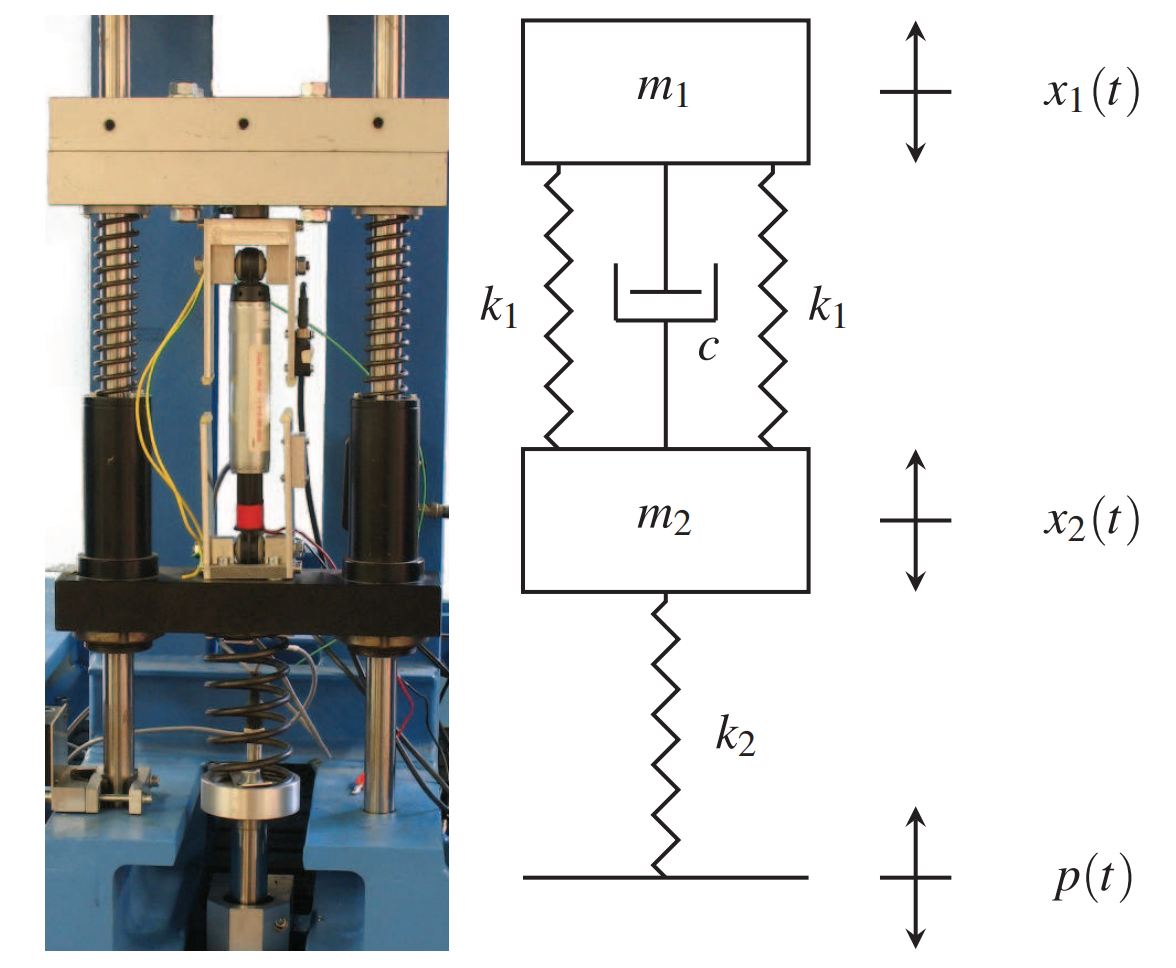

with

* $m_1 = 40 \text{ kg}$: mass of the quarter-car
* $2$*$k_1 = 9000 \frac{\text{ N}}{\text{ m}}$: stiffness of the suspension
* $c$: damping of the suspension
* $m_2 = 5 \text{ kg}$: mass of the tire
* $k_2 = 15000 \frac{\text{ N}}{\text{ m}}$: stiffness of the tire

Questions:

1. Write down the equations of motion of the quarter-car (in the time domain), in which you consider the road displacement $p(t)$ as a disturbance.

2. Simulate the behavior of the quarter-car, for a damping $c = 200 \frac{\text{ Ns}}{\text{ m}}$, starting from rest, subject to a step disturbance of $5 \text{ cm}$ in the road displacement. Plot the resulting evolution of the motion of the car as a function of time.

3. The quarter-car is equipped with a semiactive suspension, meaning that the damping $c$ is not a fixed value but can be controlled over time, hence, $c(t)$. In this assignment we make the simplified assumption that the damping can be changed instantaneously to any value between $c_{min}=0 \frac{\text{ Ns}}{\text{ m}}$ and $c_{max}=2000 \frac{\text{ Ns}}{\text{ m}}$, and we consider the following control law: 

    a. if $\dot{x}_1$ and $\dot{x}_1-\dot{x}_2$ have the same sign: $c = K \frac{\dot{x}_1}{\dot{x}_1-\dot{x}_2}$, but respecting to stay between $c_{min}$ and $c_{max}$.

    b. otherwise: $c = c_{min}$.

This is called the "skyhook control policy". Implement the equations of motion for the quarter-car with semiactive suspension. Simulate the system for a few values of $K$, for the same excitation as in question 2.

Hint: some useful CasADi functions: if_else, fmin, fmax, logsumexp. Check the CasADi documentation for more information.

4. Formulate two optimization problems to design 1) an optimal passive suspension, meaning a suspension with a fixed value of $c$, and 2) an optimal semi-active suspension with a skyhook control policy, meaning a suspension with a fixed value of $K$. Optimal means that the car body $x_1(t)$ deviates as little as possible from its steady-state value for a given road disturbance.

5. Solve both problems using CasADi-Opti with the Ipopt solver for a step disturbance of $1 \text{ cm}$, $5 \text{ cm}$, and $10 \text{ cm}$. Discuss the results.

6. Are your optimization problems convex? Motivate your answer.

7. What are computationally the most expensive parts when solving the system (look at the Ipopt output!)? Can you explain why this is the case? How would you speed up solving the problem?

# Solution

## Q1 - The equations of motion of the quarter-car are given by:

Car Body: $ \quad m_1 \ddot{x_1} = - 2 k_1 (x_1 - x_2) - c (\dot{x_1} - \dot{x_2}) $

Tire: $ \quad m_2 \ddot{x_2} = - k_2 (x_2 - p(t)) + 2 k_1 (x_1 - x_2) + c (\dot{x_1} - \dot{x_2}) $

## Q2 - Simulation of the quarter-car 

In [49]:
import numpy as np
from casadi import *
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import *
from scipy.integrate import solve_ivp
from matplotlib.patches import Circle

# Define system parameters
m1 = 40  # kg
m2 = 5   # kg
k1 = 9000   # N/m
k2 = 15000  # N/m
c = 200  # Ns/m for Q2

# Skyhook control parameters
c_min = 0  # Ns/m
c_max = 2000  # Ns/m

# Define the step disturbance
def p(t, step_size):
    return step_size if t >= 0 else 0

# Define the control law for c(t)
def semiactive_suspension(x1_dot, x2_dot, K):
    if x1_dot * (x1_dot - x2_dot) > 0:
        c = K * x1_dot / (x1_dot - x2_dot)
        c = np.clip(c, c_min, c_max)
    else:
        c = c_min
    return c

# Define the equations of motion
def equations(t, y, K, damper, step_size, skyhook=False):
    x1, x2, x1_dot, x2_dot = y
    if skyhook:
        c = semiactive_suspension(x1_dot, x2_dot, K)
    else:
        c = damper
    x1_ddot = (-k1 * (x1 - x2) - c * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - p(t, step_size)) + k1 * (x1 - x2) + c * (x1_dot - x2_dot)) / m2
    return [x1_dot, x2_dot, x1_ddot, x2_ddot]

step size: 0.05 m


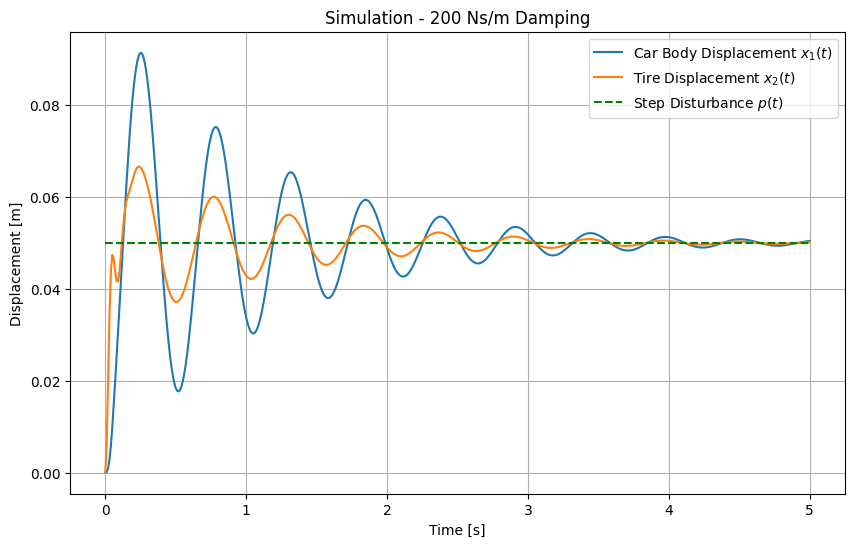

In [ ]:
def Q2(c=c, step_size=0.05):
    # Initial conditions: [x1, x2, x1_dot, x2_dot]
    y0 = [0, 0, 0, 0]

    # Time span for the simulation
    t_span = (0, 5)  # 5 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the system of differential equations
    sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, args=(0, c, step_size, False))

    # Extract the results
    x1 = sol.y[0]
    x2 = sol.y[1]
    t = sol.t

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, label='Car Body Displacement $x_1(t)$')
    plt.plot(t, x2, label='Tire Displacement $x_2(t)$')
    plt.plot(t, [step_size for _ in t], label='Step Disturbance $p(t)$', linestyle='--', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.title(f'Simulation - {c} Ns/m Damping')
    plt.legend()
    plt.grid()
    plt.show()

# Run Q2
Q2()

## Q3 - Implementation of the skyhook control policy

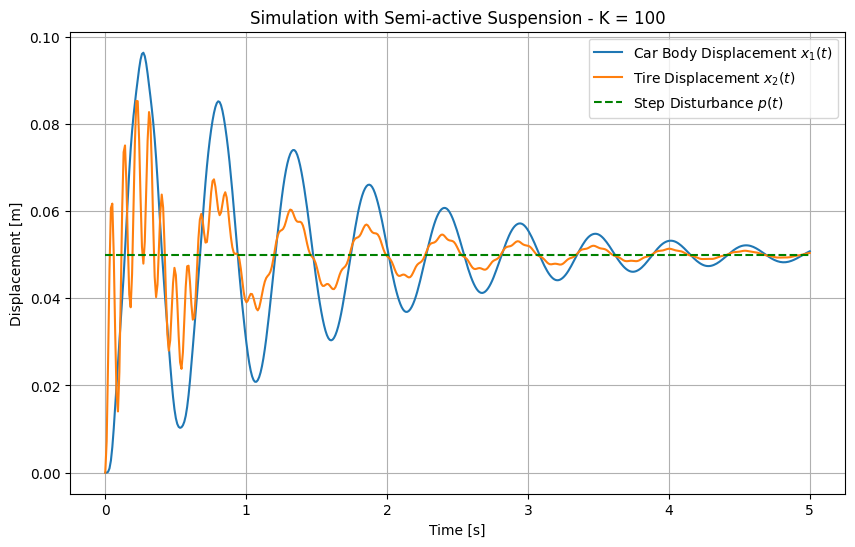

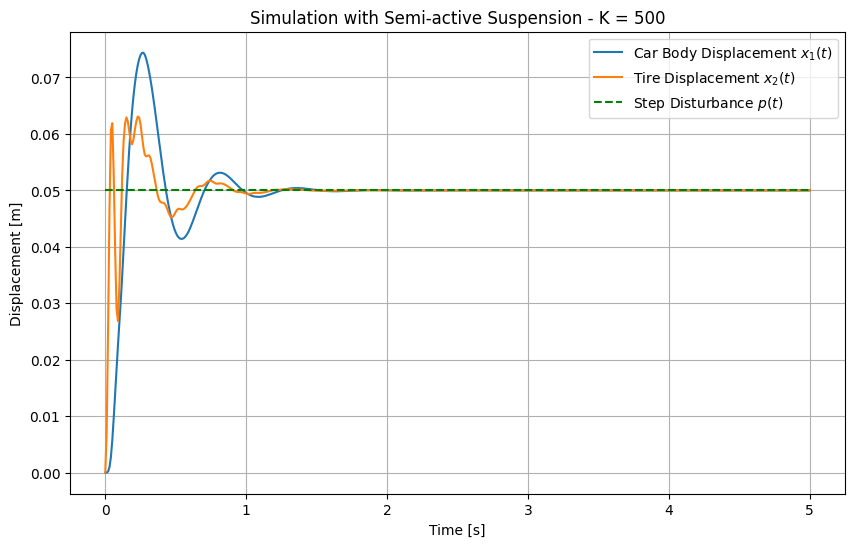

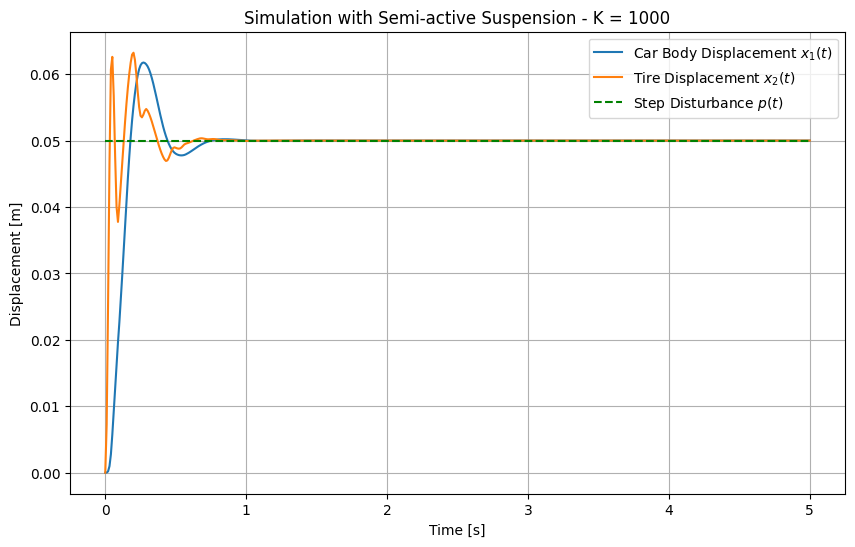

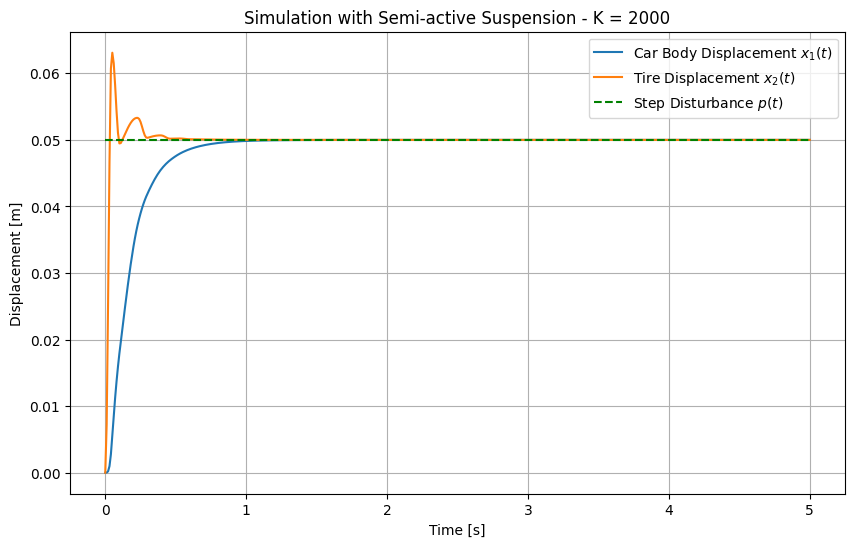

In [53]:
def Q3(K, step_size=0.05):
    # Initial conditions: [x1, x2, x1_dot, x2_dot]
    y0 = [0, 0, 0, 0]

    # Time span for the simulation
    t_span = (0, 5)  # 5 seconds
    t_eval = np.linspace(t_span[0], t_span[1], 500)

    # Solve the system of differential equations
    sol = solve_ivp(equations, t_span, y0, t_eval=t_eval, args=(K, c, step_size, True))

    # Extract the results
    x1 = sol.y[0]
    x2 = sol.y[1]
    t = sol.t

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t, x1, label='Car Body Displacement $x_1(t)$')
    plt.plot(t, x2, label='Tire Displacement $x_2(t)$')
    plt.plot(t, [step_size for _ in t], label='Step Disturbance $p(t)$', linestyle='--', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Displacement [m]')
    plt.title(f'Simulation with Semi-active Suspension - K = {K}')
    plt.legend()
    plt.grid()
    plt.show()

# Run Q3 with a different values of K
K = [100, 500, 1000, 2000]
for k in K:
    Q3(k)

## Q4 & Q5 - Formulation of the optimization problems and solutions for three road disturbances
Optimal passive suspension

Optimal damping coefficient: 1165.119295334078
step size: 0.01 m


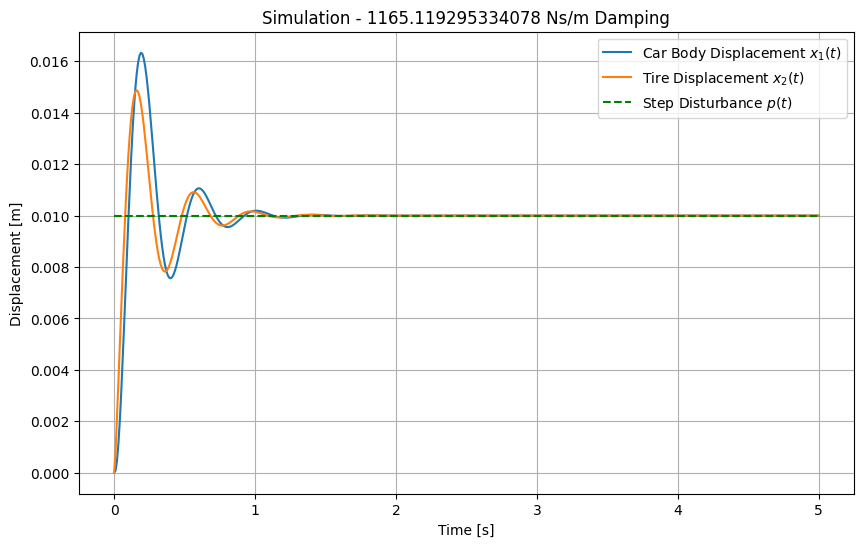

Optimal damping coefficient: 1165.3557448477966
step size: 0.05 m


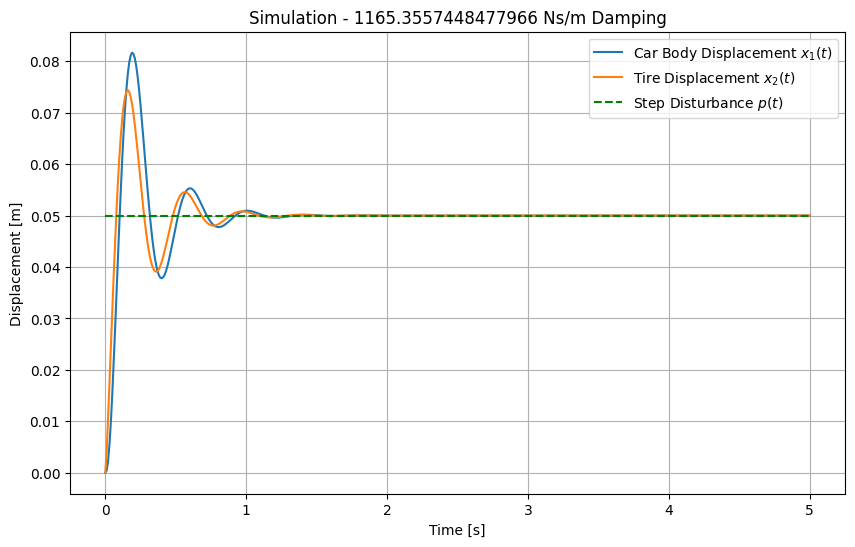

Optimal damping coefficient: 1165.8429694995675
step size: 0.1 m


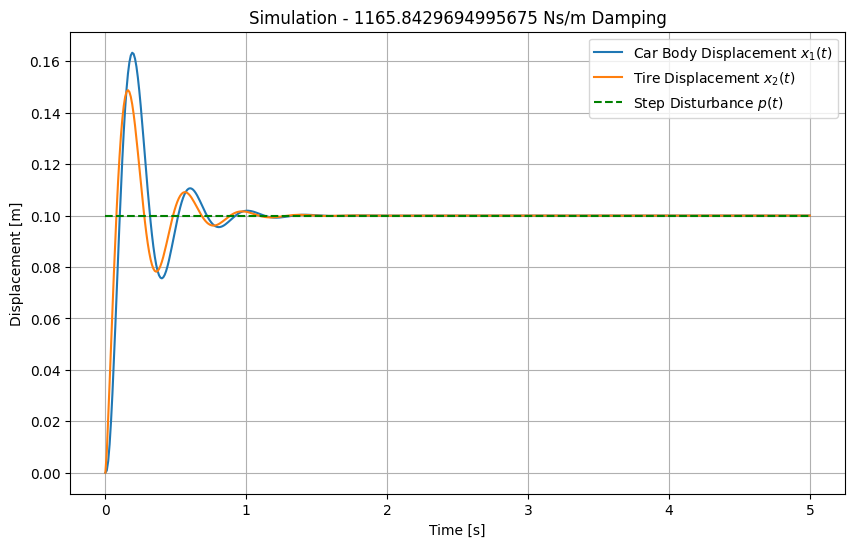

In [54]:
# Optimal passive suspension (optimal value of c)

def Q4_1(step_size):
    T = 5  # Total simulation time

    # Define the optimization problem
    opti = Opti()

    # Decision variable and constraints (within reasonable bounds)
    c = opti.variable(1, 1)
    opti.subject_to(c_min <= c)
    opti.subject_to(c <= c_max)

    # Time and state variables
    t = MX.sym('t')
    x = MX.sym('x', 4, 1)
    x1, x2, x1_dot, x2_dot = x[0], x[1], x[2], x[3]

    # Equations of motion
    x1_ddot = (-k1 * (x1 - x2) - c * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - step_size) + k1 * (x1 - x2) + c * (x1_dot - x2_dot)) / m2
    rhs = vertcat(x1_dot, x2_dot, x1_ddot, x2_ddot)

    # Define the ODE function
    ode = {'x': x, 'p': vertcat(c, t), 'ode': rhs}
    F = integrator('F', 'cvodes', ode, {'tf': T/500})

    # Initial conditions
    x0 = np.array([0, 0, 0, 0])

    # Simulate the system
    x = x0
    x1_traj = []
    for i in range(500):
        t_val = i * T / 500
        res = F(x0=x, p=vertcat(c, t_val))
        x = res['xf']
        x1_traj.append(x[0])

    # Objective function
    objective = sum1(vertcat(*x1_traj)**2)
    opti.minimize(objective)

    # Solve the optimization problem
    opti.solver('ipopt')
    opti.solver("ipopt", {"print_time":False}, {"print_level":0}) # Suppress IPOPT output
    c_opt = opti.solve().value(c)
    print(f"Optimal damping coefficient: {c_opt}")

    # Simulate the system with the optimal damping coefficient
    Q2(c=c_opt, step_size=step_size)


# Run Q4_1 with different step sizes
step_sizes = [0.01, 0.05, 0.1]
for step_size in step_sizes:
    Q4_1(step_size)

Optimal semi-active suspension

Optimal gain factor: 2390.3504073077925


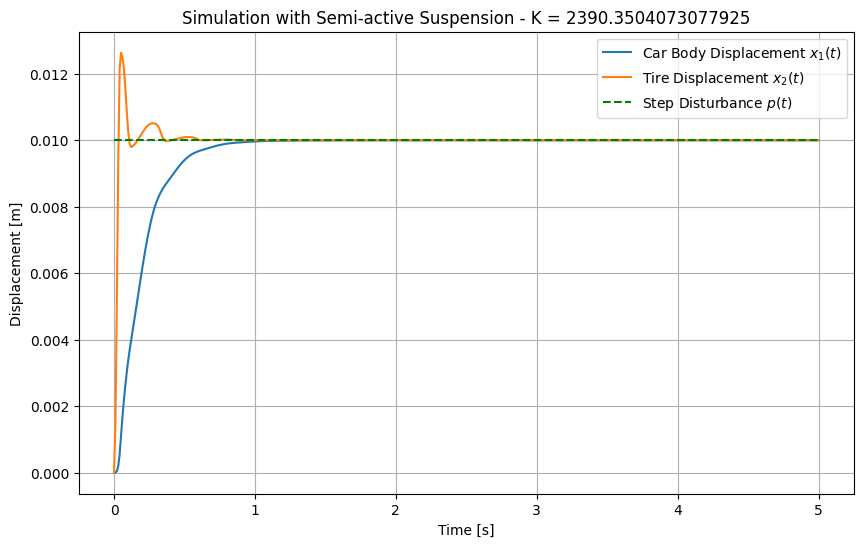

Optimal gain factor: 2390.950337655991


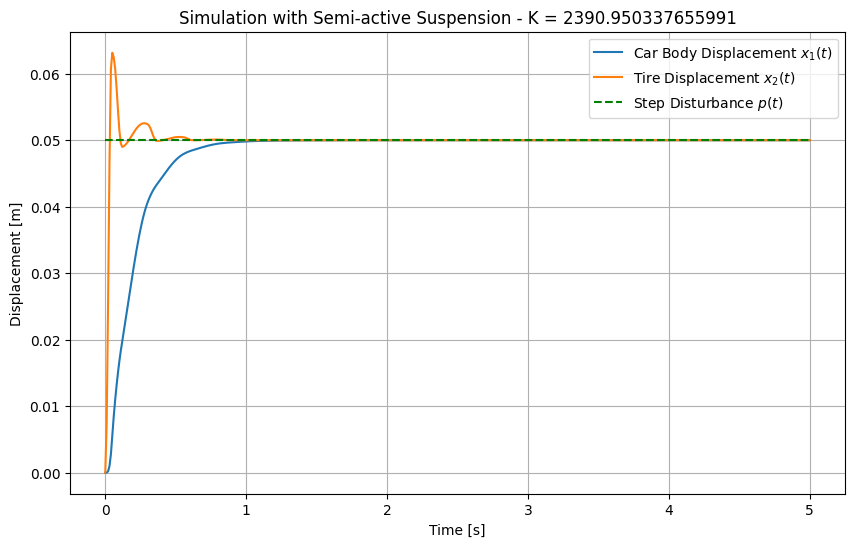

Optimal gain factor: 19999.977594628315


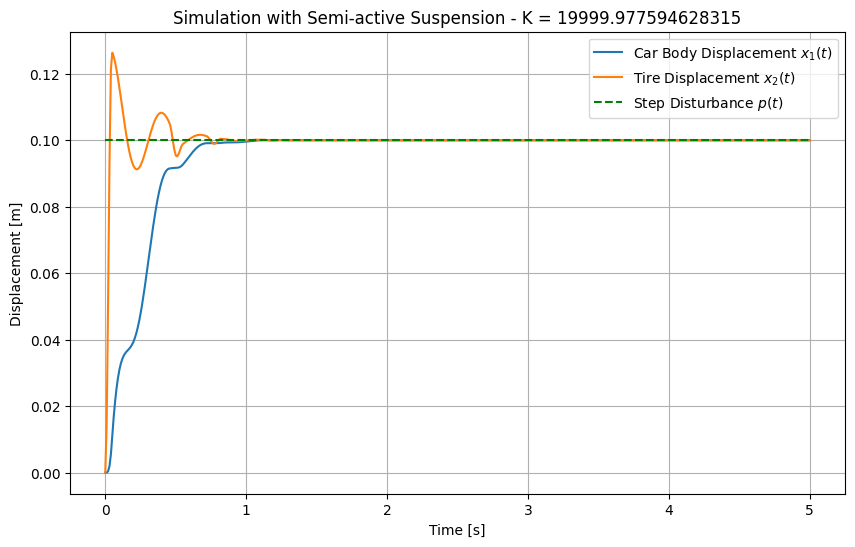

In [55]:
# Optimal semi-active suspension (optimal value of K)
def Q4_2(step_size):
    T = 5  # Total simulation time
    K_min = 0
    K_max = 20000

    # Define the optimization problem
    opti = Opti()

    # Decision variable and constraints (within reasonable bounds)
    K = opti.variable(1, 1)
    opti.subject_to(K_min <= K)
    opti.subject_to(K <= K_max)

    # Time and state variables
    t = MX.sym('t')
    x = MX.sym('x', 4, 1)
    x1, x2, x1_dot, x2_dot = x[0], x[1], x[2], x[3]

    def casadi_semiactive_suspension(x1_dot, x2_dot, K):
        return if_else(x1_dot * (x1_dot - x2_dot) > 0, 
                        if_else(K * x1_dot / (x1_dot - x2_dot) > c_max, c_max, K * x1_dot / (x1_dot - x2_dot)), 
                        c_min)

    # Equations of motion
    x1_ddot = (-k1 * (x1 - x2) - casadi_semiactive_suspension(x1_dot, x2_dot, K) * (x1_dot - x2_dot)) / m1
    x2_ddot = (-k2 * (x2 - step_size) + k1 * (x1 - x2) + casadi_semiactive_suspension(x1_dot, x2_dot, K) * (x1_dot - x2_dot)) / m2
    rhs = vertcat(x1_dot, x2_dot, x1_ddot, x2_ddot)

    # Define the ODE function
    ode = {'x': x, 'p': vertcat(K, t), 'ode': rhs}
    F = integrator('F', 'cvodes', ode, {'tf': T/500})

    # Initial conditions
    x0 = np.array([0, 0, 0, 0])

    # Simulate the system
    x = x0
    x1_traj = []
    for i in range(500):
        t_val = i * T / 500
        res = F(x0=x, p=vertcat(K, t_val))
        x = res['xf']
        x1_traj.append(x[0])

    # Objective function
    objective = sum1(vertcat(*x1_traj)**2)
    opti.minimize(objective)

    # Solve the optimization problem
    opti.solver('ipopt')
    opti.solver("ipopt", {"print_time":False}, {"print_level":0}) # Suppress IPOPT output
    K_opt = opti.solve().value(K)
    print(f"Optimal gain factor: {K_opt}")

    # Simulate the system with the optimal gain factor
    Q3(K_opt, step_size)


# Run Q4_2 with different step sizes
step_sizes = [0.01, 0.05, 0.1]
for step_size in step_sizes:
    Q4_2(step_size)

## Q6 - Convexity of the optimization problems (TO CHECK)
1. Optimal passive suspension problem: 
    1. The decision variables are $c$ and $x_1(t)$. $c$ is constrained to be whithin the range $[c_{min}, c_{max}]$ which is a convex constraints.
    2. The equation of motion of the car body define $\ddot{x}_1$ and $\ddot{x}_2$. These involve nonlinear terms such as products of the damping coefficient $c$ and velocity differences, making the dynamics nonlinear. (not sure about this)
    3. The objective function is the squared deviation of the car body from its steady-state value. However $x_1$ depends on the nonlinear dynamics, so the relationship is nonlinear.
    
    The optimization problem is not guaranteed to be convex because:
    - The dynamics are nonlinear and introduce non-convexity into the system.
    - The objective function is based on these dynamics and is thus likely to be non-convex.

2. Optimal semi-active suspension problem:
    1. The decision variables are $K$ and $x_1(t)$. $K$ is constrained to be whithin the range $[K_{min}, K_{max}]$ which is a convex constraints.
    2. The function that defines the damping coefficient $c$ is a piecewise function of the velocity differences. It uses "if_else" structure, which introduces nonlinearity due to conditional branching. Additionally, there is a min-operator adding more nonlinearity. (As a consequence it is not convex - not sure about this)
    3. The equation of motion for $\ddot{x}_1$ and $\ddot{x}_2$ involve the nonlinear function "casadi_semiactive_suspension", making the dynamics non-affine and likely non-convex in $K$.

    This optimization problem is not convex because:
    - The function "casadi_semiactive_suspension" introduces significant nonlinearity and non-convexity.
    - The dynamics depend on this nonlinear function, propagating non-convexity to the objective function.